# Predict Flat Value - And which are the most important features to define it

In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

pd.set_option('display.max_columns', None)

## 0. Reading

Firstly, we read the files generated previously through web scraping.

In [3]:
df_p1 = pd.read_csv("data/data1.csv")
df_p2 = pd.read_csv("data/data2.csv")
df_p3 = pd.read_csv("data/data70_140.csv")
df_p4 = pd.read_csv("data/data140_210.csv")
df_p5 = pd.read_csv("data/data210_310.csv")
df_p6 = pd.read_csv("data/data310_410.csv")
df_p7 = pd.read_csv("data/data410_500.csv")
df_p8 = pd.read_csv("data/data500_510.csv")

df = pd.concat([df_p1, df_p2, df_p3, df_p4, df_p5, df_p6, df_p7, df_p8]).drop_duplicates()

## 1. Data Cleaning and Preprocessing

The first part of a Data Science / Data Analysis project is the Data Cleaning and Preprocessing. Obviously, after the Problem Definition and Understanding, and the Data Collection, which we already did. \
We decided that if a flat attribute has both a descriptive and a numerical feature, we opted for the descriptive one to prevail, as after studying it, we considered it to provide more reliability. This may lead to some extra processing in the future (doing a data transformation of for example "6ª planta" to 6), but it will have been worth it.
Hence, we drop columns because we decided to prevail the descriptive ones, or we decided are irrelevant after looking the boxplots.

In [4]:
print("Initial dataframe shape:", df.shape)

Initial dataframe shape: (9684, 114)


In [5]:
# rename columns to a better clarity
df = df.rename(columns={"orientation.1":"orientation_desc", "floor.1":"floor_desc", "antiquity.1":"antiquity_desc", "conservationState.1":"conservationState_desc", "hotWater.1":"hotWater_type_desc", "heating.1":"heating_desc"})

# filtering to have reasonable data
df = df[(df["value"]>0) & (df["surface"]>0) & (df["surface"].notna()) & (df["surface"] < 1000) & (df["energy_value"]<999) & (df["environment_value"]<999) & (df["value"].notna())].reset_index(drop=True)

# We drop the following columns because we decided to prevail the descriptive ones, or we decided are irrelevant after looking the EDA
cols_drop = ["type", "subtype", "external_contract", "invalid", "transactions", "transaction_type", "periodicity_id", "energyCertificate", "surfaceLand", "countryId", "level1Id",
             "level2Id", "level3Id", "level4Id", "level5Id", "level6Id", "level7Id", "level8Id",
             "conservationState", "orientation", "hotWater", "heating", "antiquity", "highlight", "Muebles de diseño", "Música ambiental","Sala de cine",
             "id","accuracy"]
try: df = df.drop(columns=cols_drop)
except: print("Some error ocurred. Maybe already dropped columns")


### Column types

Here, we only check the data types and change them if needed. For example, because of how we gather and process information during the scraping process, some features may initially be stored as numbers when they should actually be boolean values.

In [6]:
# df.info()

In [7]:
# changing dtypes in some columns
df["date"] = pd.to_datetime(df["date"].str[:10])
multimedia_columns = ["multimedia_type_2","multimedia_type_6","multimedia_type_12","multimedia_type_21","multimedia_type_5"]
df[multimedia_columns] = df[multimedia_columns].fillna(0).astype(int)

# processing boolean features (df.columns[45:87])
bool_features_cols = [
    'furnished','parking', 'Aire acondicionado', 'Parquet', 'Horno', 'Microondas',
    'Serv. portería', 'Balcón', 'Lavadero', 'Armarios', 'Calefacción',
    'Suite - con baño', 'Nevera', 'Puerta Blindada', 'Terraza',
    'Electrodomésticos', 'Alarma', 'Cocina Equipada', 'Lavadora',
    'Cocina Office', 'Patio', 'Videoportero', 'Piscina', 'Gres Cerámica',
    'Jardín Privado', 'Trastero', 'Internet', 'Domótica', 'TV',
    'Ascensor interior', 'Sistema Video vigilancia CCTV 24h',
    'Z. Comunitaria', 'Zona Deportiva', 'Zona Infantil',
    'Piscina comunitaria', 'Gimnasio', 'Baño de huéspedes',
    'Cuarto para el servicio', 'Jacuzzi', 'Bodega', 'Sauna',
    'Cuarto lavado plancha', 'Energía Solar', 'elevator', 'Pista de Tenis', 'Porche cubierto'
] 
for colname in bool_features_cols:
    df[colname] = np.where(df[colname]>0, True, False)

df["energy_letter"] = df["energy_letter"].astype('O')
df["environment_letter"] = df["environment_letter"].astype('O')

### Outliers removal

**Tukey's method** is based on interquartile range (IQR) and is robust to skewed distributions, while the **z-score method** 
relies on mean and standard deviation and is sensitive to extreme values. The choice between these methods depends 
on the nature of our data and the specific requirements of our analysis. It's often a good practice to try both 
methods and compare their effects. \
We decided to keep the **Tukey's method** results.

IQR: 5696 | Actual: 6185 | 92.09%
Z-score: 5922 | Actual: 6185 | 95.75%


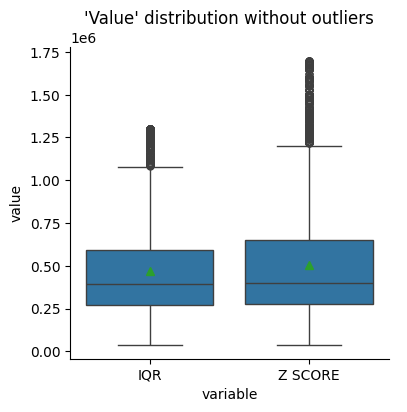

In [8]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_zscore(df, column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_iqr = remove_outliers_iqr(df, "value").copy()
df_z = remove_outliers_zscore(df, "value").copy()

print(f"IQR: {len(df_iqr)} | Actual: {len(df)} | {(len(df_iqr)/len(df))*100:.2f}%")
print(f"Z-score: {len(df_z)} | Actual: {len(df)} | {(len(df_z)/len(df))*100:.2f}%")

df_iqr['variable'] = 'IQR'
df_z['variable'] = 'Z SCORE'
combined_df = pd.concat([df_iqr, df_z], axis=0)
sns.catplot(data=combined_df, kind='box', x='variable', y='value', showmeans=True, height=4, aspect=1)
plt.title("'Value' distribution without outliers")
plt.show()

In [9]:
df = remove_outliers_iqr(df, "value").reset_index(drop=True).copy()

duplicates_columns = ["value", "zipcode", "energy_value", "energy_letter","environment_value", "rooms", "bathrooms", "surface", "floor", "upperLevel"]
df = df.drop_duplicates(subset=duplicates_columns, keep='first')

print("Final dataset shape, after removing outliers and drop duplicates: ", df.shape)

Final dataset shape, after removing outliers and drop duplicates:  (4395, 85)


### Null imputation

In [10]:
def boxplot_frequencies(column, sort_column, data):
    fig, ax1 = plt.subplots(figsize=(12,3))
    df_plot = data[list(set([column, "value",sort_column]))].fillna('NA').sort_values(sort_column)
    ax1.bar(df_plot[column].unique(), df_plot.groupby(sort_column).size(), color='lightgrey')
    ax1.set_ylabel("count")
    ax2 = ax1.twinx()
    sns.boxplot(data=df_plot, x=column, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1.tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {column}")
    plt.show()

def plot_boxplot_frequencies(columns, sort_columns, data):
    for column, sort_column in zip(columns, sort_columns):
        boxplot_frequencies(column, sort_column, data)
        

Surprisingly, after this preprocessing, there are only the following columns that contain missing values. \
The first thing we need to ask ourselves is whether the column with nulls actually provides relevant information. If it's not a relevant column, we simply remove it directly, and there's no need for null imputation.

**How do we know if a feature is relevant?** Analyzing the different features at the EDA part. That's why a Data Science project is an iterative or circular process. Although EDA usually goes after null imputation and data pre-processing, we can need EDA to decide which null imputation do or if it is needed. \
Same happens in feature engineering. Depending on how we decide to transform features, nulls can be imputed differently, and we will need to go to previous stages and change the code.


In [11]:
print(df.isna().sum()[df.isna().sum()>0])

advertiser                   6
description                 20
ubication                  943
orientation_desc          1901
floor_desc                 945
antiquity_desc             935
conservationState_desc    1466
hotWater_type_desc        3040
heating_desc              2985
level6                    4395
level8                      77
dtype: int64


**What we will do with missings:**
- Advertiser, description and ubication are really specific features and makes no sense to do any type of imputation. Surely we will drop it.
- We can get rid of 'level6', since it is a general feature. The 'level8' is more important, as it is a specific geographical feature and has really correlation with the 'value'. We should get rid of the examples with missings in this column.
- In the other descriptive features, we have to decide if fill with "NA" or not. After tried their perfonmance on the different models, we decided to keep the missing values, as we use a tree-based algorithm, and can deal with nans, and the performance is better rather than filling with NA.

In [12]:
df_nonull = df.copy()
df_nonull = df_nonull.drop(columns=["level6"])
df_nonull = df_nonull[df_nonull.level8.notna()].reset_index(drop=True)

The **floor_desc** feature is the most difficult to impute, as we suppose it is an important factor to decide the value of a flat (as we can see in the EDA boxplots, it significantly affects the value).\
It is also difficult encode at Feature Engineering part, because it can behave like a descriptive feature with different categories: "sótano", "subsótano", "bajos", and therefore, be encoded with a **one-hot encodong**; or it can behave like numbers in order: "1st floor", "2nd floor", and then encode it with a **ordinal encoding**, as it is quantificable.

After analyzing their performance with different models. We also decided to keep the missing values, as we will use a one-hot encoding, and it will deal with nan values. Hence, we won't impute it with the average floor value depending on the neighborhood, or some imputations that can imagine. 

## 2. Exploratory Data Analysis

At the **Exploratory Data Analysis part**, the objective is to understand and analyze the data, identify patterns, biases, correlations, see how the features affect the target, and gaining insights before we go to the modelling part. It will also help us to do a better feature engineering and feature selection.

In [13]:
df_des = df_nonull.select_dtypes(include = ['O'])
df_num = df_nonull.select_dtypes(include = ['int64','float64'])
df_bool = df_nonull.select_dtypes(include = ['bool'])

### Target Variable: Value

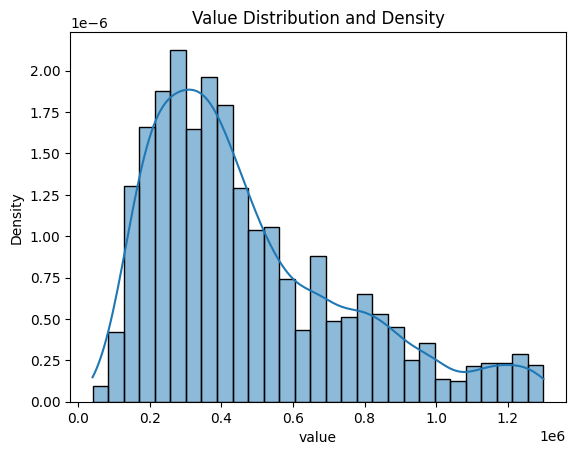

The average price per flat in Barcelona is: 475086€
The median is: 395000€


In [14]:
sns.histplot(df_nonull.value, kde=True, stat="density")
plt.title("Value Distribution and Density")
plt.show()
print(f"The average price per flat in Barcelona is: {np.mean(df_nonull['value']):.0f}€")
print(f"The median is: {np.median(df_nonull['value']):.0f}€")

### Descriptive Variables General Plots

In [15]:
print("Descriptive columns: ", ', '.join(df_des.columns))

Descriptive columns:  advertiser, description, ubication, energy_letter, environment_letter, orientation_desc, floor_desc, antiquity_desc, conservationState_desc, hotWater_type_desc, heating_desc, country, level1, level2, level3, level4, level5, level7, level8, upperLevel


In regression projects, I really like to use **boxplots** to see how the descriptive features affect the target.\
- floor_desc: ascending pattern in numerical floors from 1 to 9.
- energy_letter: descending pattern (0 is missing value).
- environment_letter: descending pattern (0 is missing value).
- orientation_desc: orientations that contain south and east are usually more expensive.
- antiquity: logical descending pattern from "5-10" to "50-70"
- hotWater_type_desc and heating_desc: not enough data to extract conclusions
- level7 (district): totally affects the value. level8 (neighborhood) will be the most important feature.

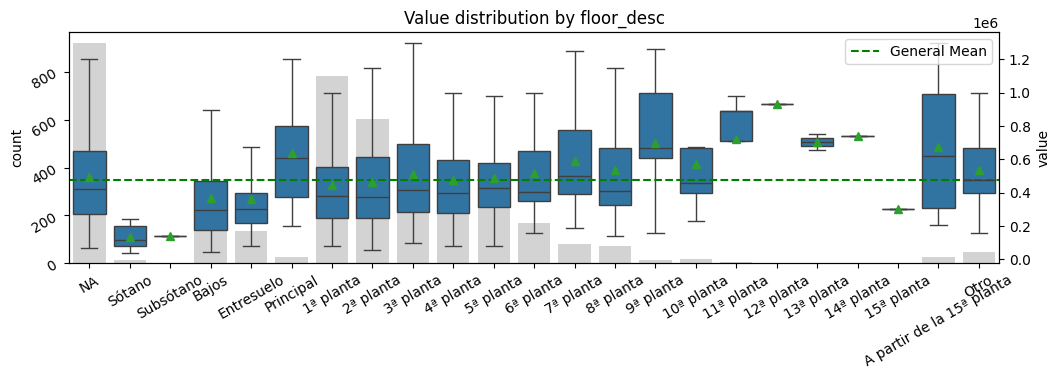

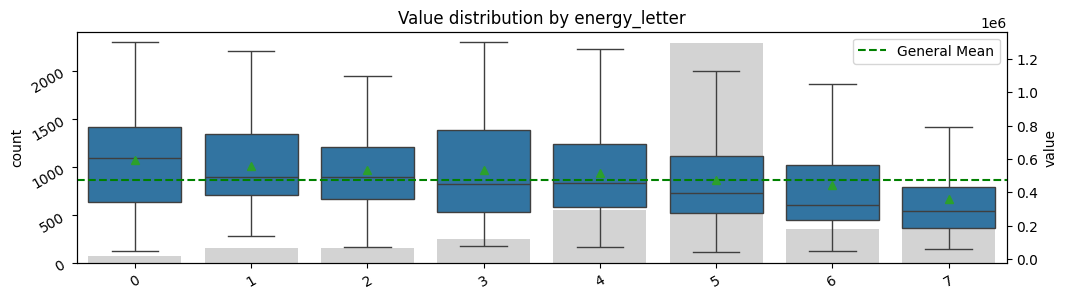

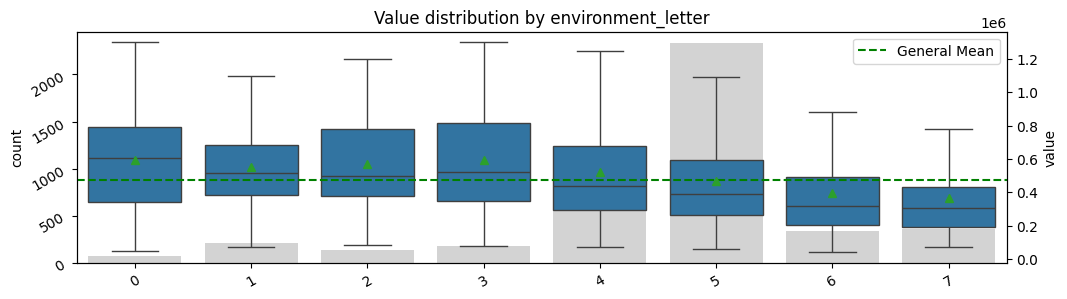

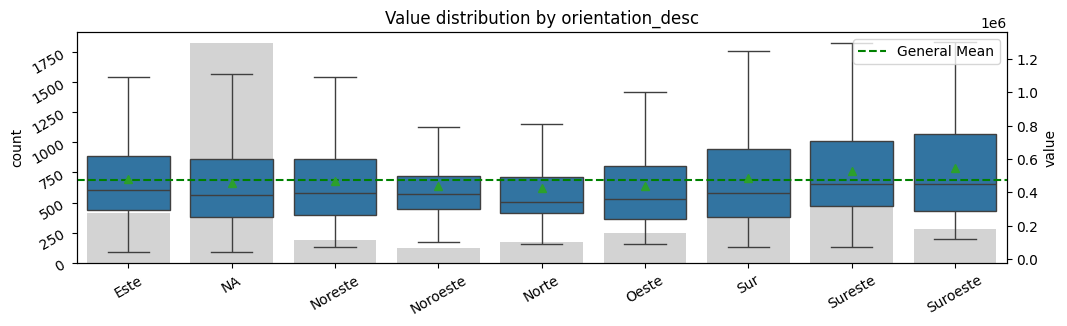

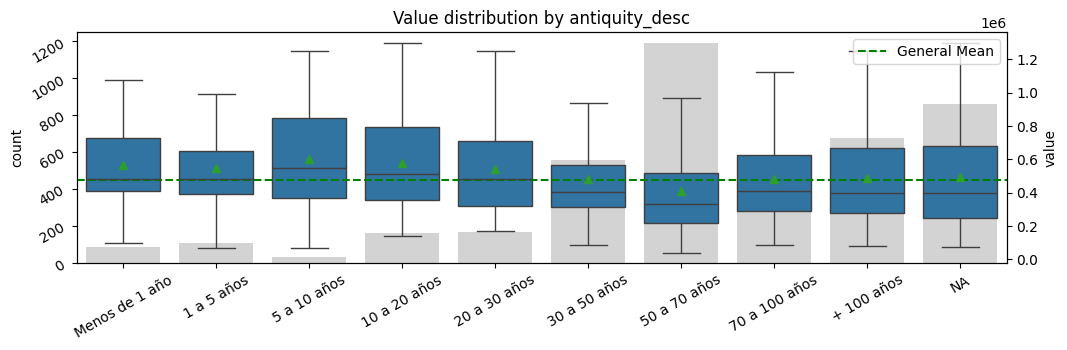

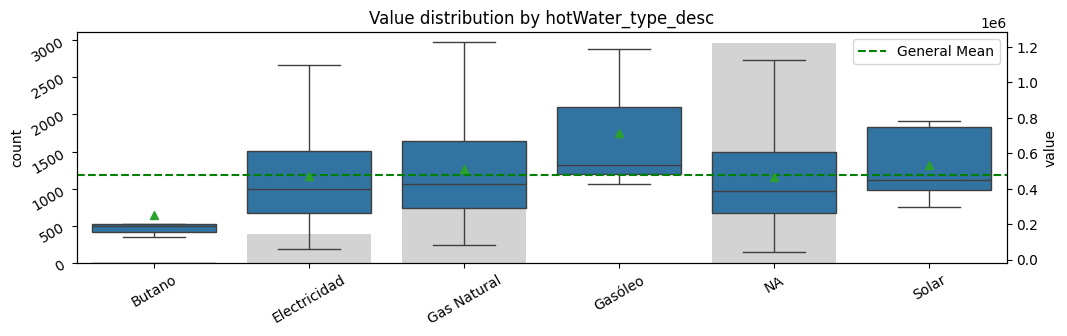

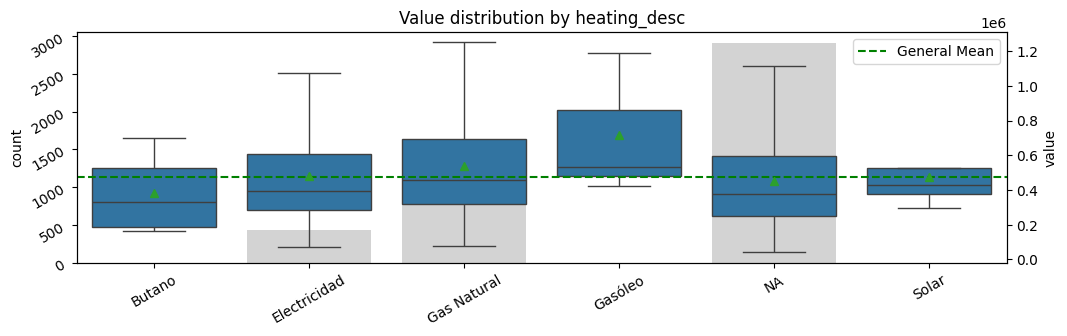

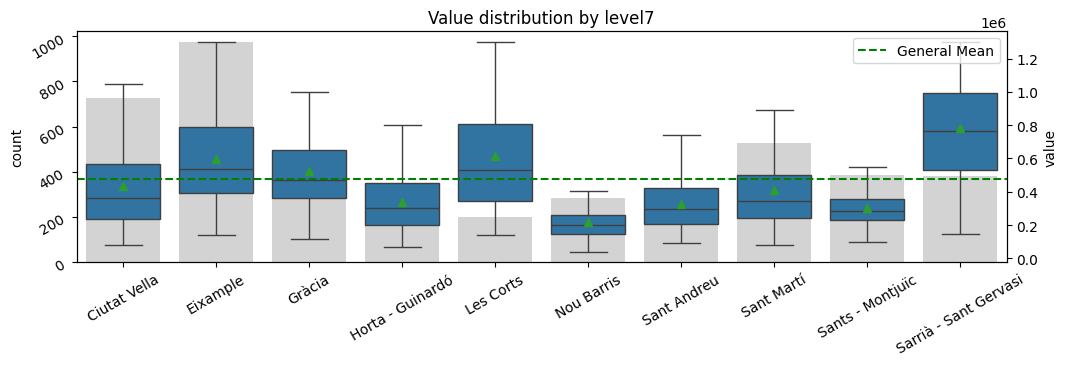

In [16]:
df_nonull["order_antiquity"] = df_nonull["antiquity_desc"].fillna("NA").replace({"1 a 5 años":1,"5 a 10 años":2,"10 a 20 años":3,
                                                                   "20 a 30 años":4,"30 a 50 años":5,"50 a 70 años":6,
                                                                   "70 a 100 años":7,"Menos de 1 año":0,"1 a 5 años":1,
                                                                                 "+ 100 años":8, "NA":50})

des_plot_features = ['floor_desc','energy_letter','environment_letter','orientation_desc','antiquity_desc','hotWater_type_desc','heating_desc','level7']
des_plot_order = ['floor','energy_letter','environment_letter','orientation_desc','order_antiquity','hotWater_type_desc','heating_desc','level7']
plot_boxplot_frequencies(des_plot_features, des_plot_order, df_nonull)


### Boolean Variables General Plots

In [17]:
print("Boolean columns: ", ', '.join(df_bool.columns),"| length:", len(df_bool.columns))


Boolean columns:  new, elevator, furnished, parking, Aire acondicionado, Parquet, Horno, Microondas, Serv. portería, Balcón, Lavadero, Armarios, Calefacción, Suite - con baño, Nevera, Puerta Blindada, Terraza, Electrodomésticos, Alarma, Cocina Equipada, Lavadora, Cocina Office, Patio, Videoportero, Piscina, Gres Cerámica, Jardín Privado, Trastero, Internet, Domótica, TV, Ascensor interior, Sistema Video vigilancia CCTV 24h, Z. Comunitaria, Zona Deportiva, Zona Infantil, Piscina comunitaria, Gimnasio, Baño de huéspedes, Cuarto para el servicio, Jacuzzi, Bodega, Sauna, Cuarto lavado plancha, Energía Solar, Pista de Tenis, Porche cubierto | length: 47


Too much boxplots to see, but we can observe ealisy **which variables are worth to use at the modelling part** (depending on how they affect the target and if we have the exaples correctly distributed). For example:
"elevator","parking","Aire acondicionado","Parquet","Serv. portería","Balcón","Armarios","Calefacción","Suite - con baño","Terraza","Alarma","Cocina Equipada","Piscina","Trastero","Gres Cerámica","Jardín Privado".

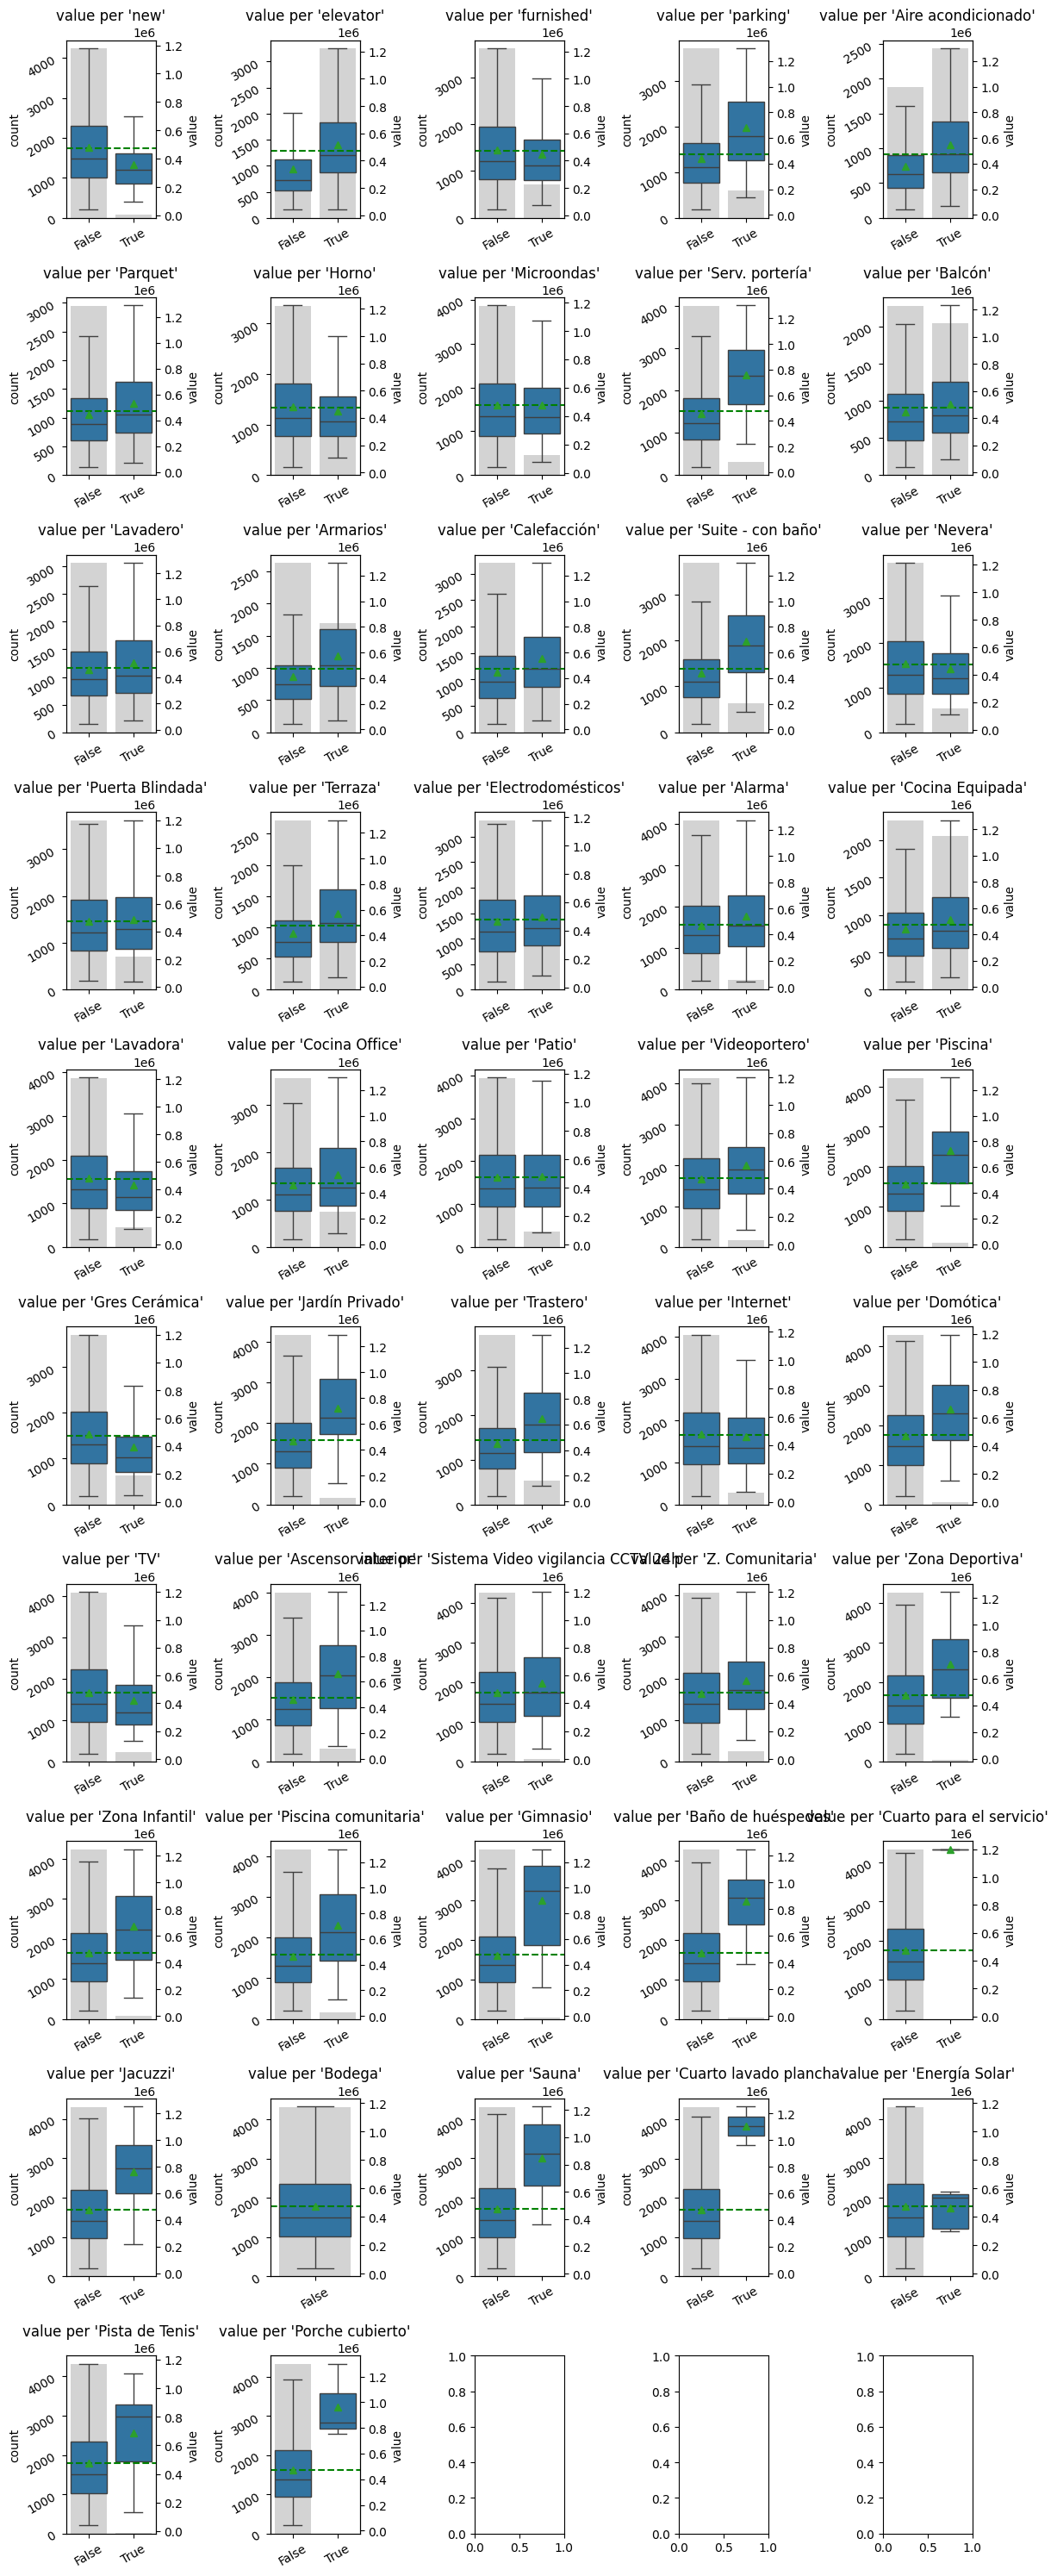

In [18]:
def plot_boxplot_frequencies_subplots(columns, sort_columns, data, nrows, ncols):
    fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,nrows*3))
    ax1 = ax1.flatten()
    i=0
    for column, sort_column in zip(columns, sort_columns):
        df_plot = data[list(set([column, "value",sort_column]))].fillna('NA').sort_values(sort_column)
        ax1[i].bar(df_plot[column].unique(), df_plot.groupby(sort_column).size(), color='lightgrey')
        ax1[i].set_ylabel("count")
        ax2 = ax1[i].twinx()
        sns.boxplot(data=df_plot, x=column, y='value', showfliers=False, showmeans=True, ax=ax2)
        plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
        ax1[i].tick_params(labelrotation=30)
        plt.title(f"value per '{column}'")
        i+=1    
    fig.tight_layout()
    plt.show()

plot_boxplot_frequencies_subplots(df_bool.columns, df_bool.columns, df_nonull, 10, 5)

### Numerical Variables General Plots

This time, I have followed these steps:
1. Describe the variables to see basic statistical factors.
2. Correlation matrix to see which variables are more correlated with the value, and try to not use too correlated ones.
3. Histograms to see how data is distributed on an easy way.
4. Other.

In [19]:
print("Numerical columns: ", ', '.join(df_num.columns))
df_nonull = df_nonull.drop(columns=["latitude", "longitude", "zipcode"])


Numerical columns:  value, reduced, zipcode, energy_value, environment_value, multimedia_type_2, multimedia_type_6, multimedia_type_12, multimedia_type_21, multimedia_type_5, rooms, bathrooms, surface, floor, latitude, longitude


In [20]:
df_num = df_nonull.select_dtypes(include = ['int64','float64'])
df_num.describe()

,value,reduced,energy_value,environment_value,multimedia_type_2,multimedia_type_6,multimedia_type_12,multimedia_type_21,multimedia_type_5,rooms,bathrooms,surface,floor,order_antiquity
count,4.318000e+03,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000
mean,4.750861e+05,12220.607689,150.850035,44.787390,27.644048,0.148912,0.122510,0.201019,0.022696,2.851088,1.610699,99.559750,6.216999,14.576887
std,2.798971e+05,33257.410667,88.502099,51.437326,12.148242,0.411568,0.333516,0.474876,0.177346,1.093630,0.730326,46.193398,4.673983,17.720333
min,3.990000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,2.650000e+05,0.000000,100.000000,23.000000,19.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,69.000000,3.000000,5.000000
50%,3.950000e+05,0.000000,145.000000,34.250000,26.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,88.000000,7.000000,6.000000
75%,6.300000e+05,10000.000000,192.000000,49.000000,34.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,119.000000,9.000000,8.000000
max,1.300000e+06,425000.000000,960.000000,978.000000,107.000000,4.000000,2.000000,3.000000,4.000000,8.000000,10.000000,515.000000,31.000000,50.000000


In [21]:
corr = df_num.corr()
corr.style.background_gradient(cmap='coolwarm')

,value,reduced,energy_value,environment_value,multimedia_type_2,multimedia_type_6,multimedia_type_12,multimedia_type_21,multimedia_type_5,rooms,bathrooms,surface,floor,order_antiquity
value,1.000000,0.252285,-0.176486,-0.144000,0.436726,-0.035714,0.042199,0.128340,0.044306,0.392489,0.669318,0.771956,0.072199,0.019887
reduced,0.252285,1.000000,-0.002413,-0.014331,0.144858,0.011085,0.048890,0.097818,-0.043855,0.124259,0.199595,0.258274,0.043186,-0.009166
energy_value,-0.176486,-0.002413,1.000000,0.372755,-0.073447,0.016165,0.001693,-0.009931,-0.132457,-0.011760,-0.123606,-0.101948,-0.001367,-0.031793
environment_value,-0.144000,-0.014331,0.372755,1.000000,-0.064973,-0.013493,-0.041155,-0.092336,-0.082560,-0.004163,-0.103177,-0.091402,0.019676,0.011888
multimedia_type_2,0.436726,0.144858,-0.073447,-0.064973,1.000000,0.074539,0.124996,0.108734,0.048048,0.295987,0.375227,0.437619,0.015443,-0.053109
multimedia_type_6,-0.035714,0.011085,0.016165,-0.013493,0.074539,1.000000,0.066196,-0.061933,0.048895,-0.006819,-0.012854,-0.022893,0.084108,-0.051801
multimedia_type_12,0.042199,0.048890,0.001693,-0.041155,0.124996,0.066196,1.000000,0.082871,0.015642,0.026530,0.033228,0.040369,0.016080,-0.025875
multimedia_type_21,0.128340,0.097818,-0.009931,-0.092336,0.108734,-0.061933,0.082871,1.000000,-0.054185,0.021077,0.086771,0.090932,-0.023310,-0.028181
multimedia_type_5,0.044306,-0.043855,-0.132457,-0.082560,0.048048,0.048895,0.015642,-0.054185,1.000000,-0.057814,0.032463,-0.007235,-0.078601,0.255881
rooms,0.392489,0.124259,-0.011760,-0.004163,0.295987,-0.006819,0.026530,0.021077,-0.057814,1.000000,0.484533,0.627947,0.021368,-0.057997


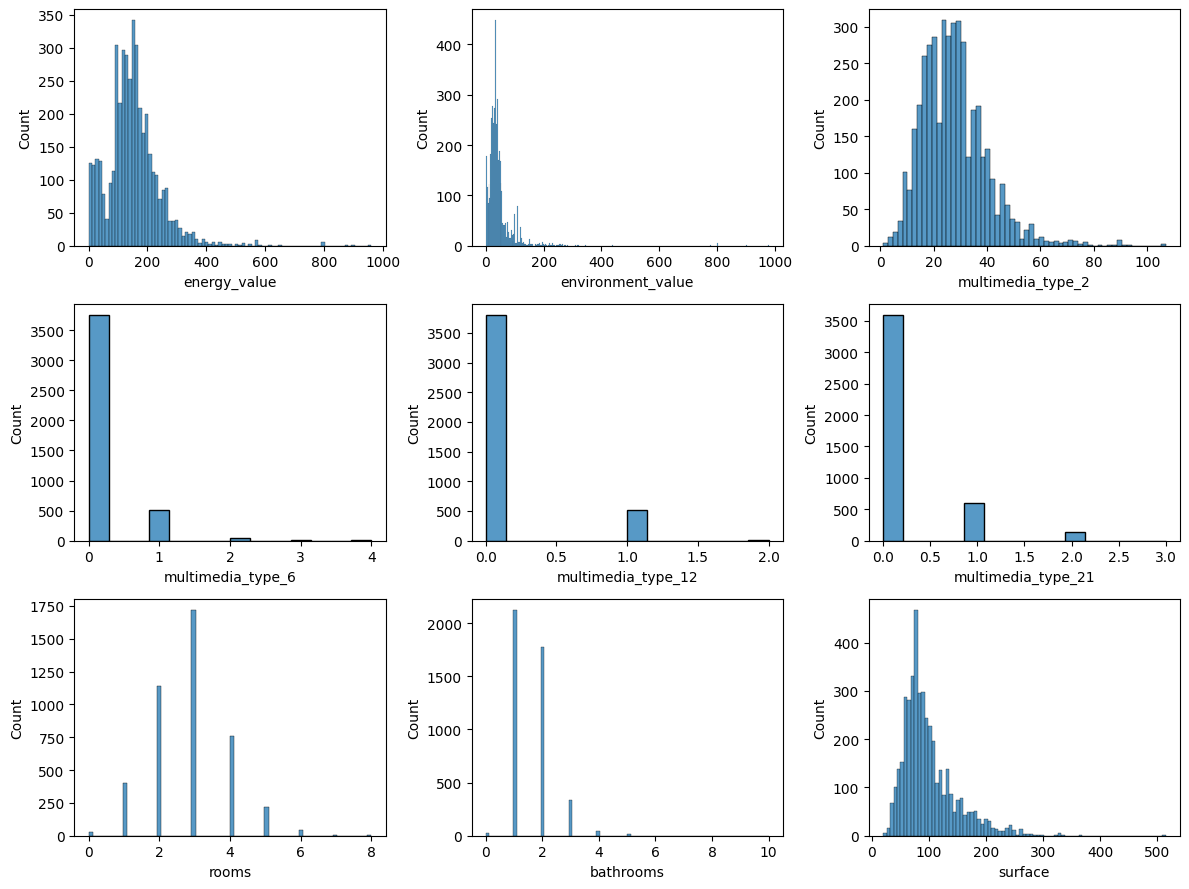

In [22]:
columns = ['energy_value', 'environment_value','multimedia_type_2', 'multimedia_type_6', 'multimedia_type_12',
           'multimedia_type_21', 'rooms', 'bathrooms', 'surface'] # 'multimedia_type_5'
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))
ax = ax.flatten()
for i, column in enumerate(columns):
    sns.histplot(df_num[column], ax=ax[i])
fig.tight_layout()
plt.show()

**lmplot** is a really good way to see how two numerical variables are correlated, depending on a descriptive variable. For example, surface and value are correlated, but not always with the same ratio. When we increase the surface, the value increases much more faster in "Les Corts" than in "Nou Barris".

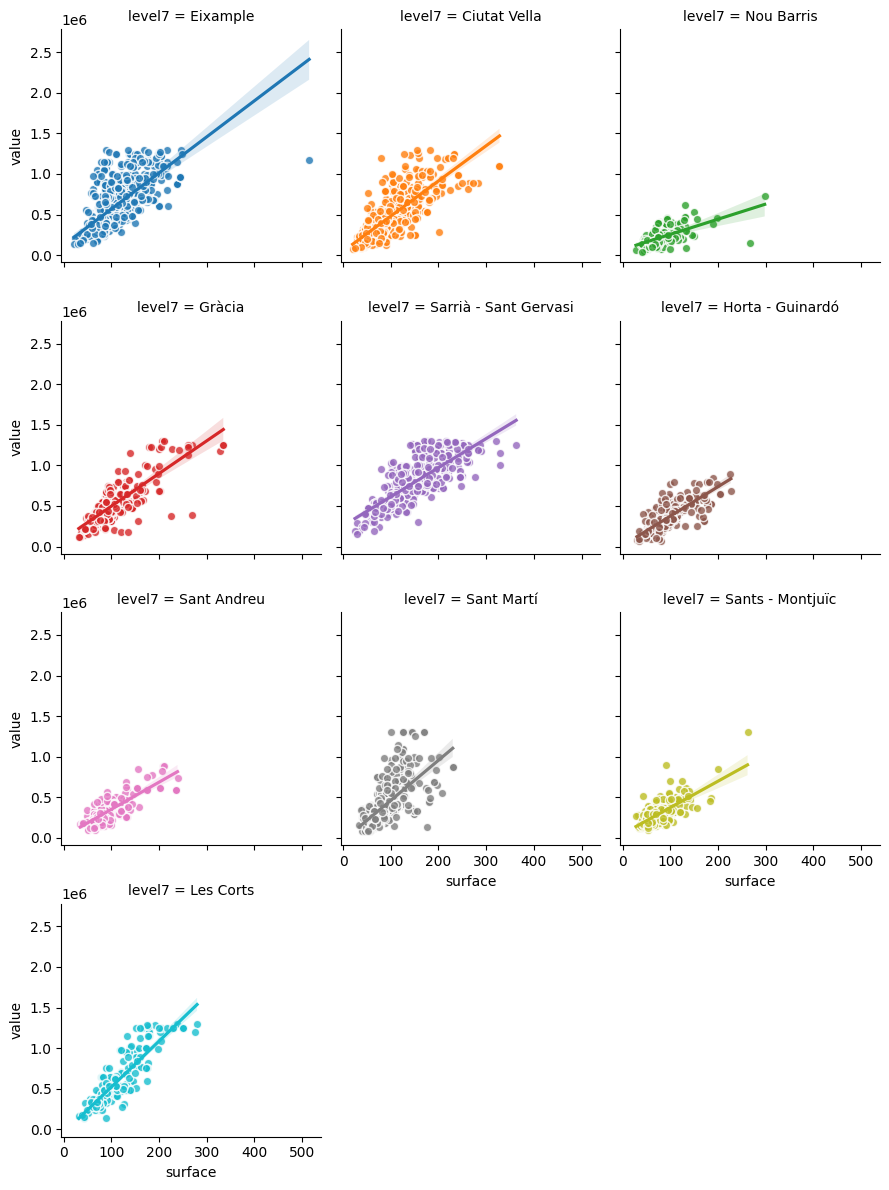

In [23]:
sns.lmplot(data=df_nonull, x="surface", y="value", col="level7", hue="level7",scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=3)
plt.show()

Number of bathrooms has a logical ascending pattern.

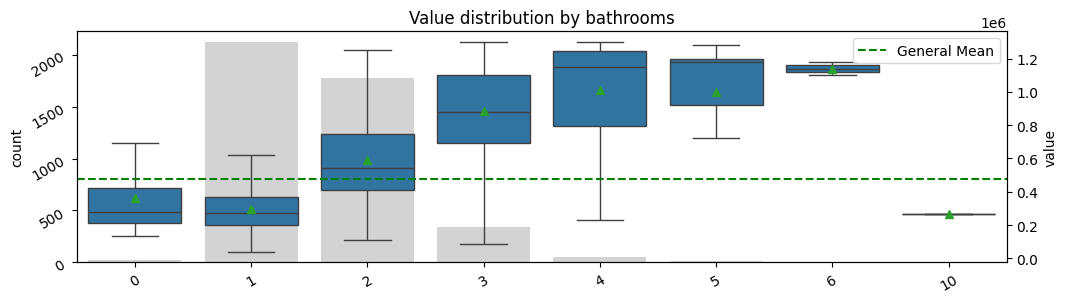

In [24]:
plot_boxplot_frequencies(["bathrooms"], ["bathrooms"], df_nonull)

The behabvior of the value depending on the number of multimedia_type_2 (number of pictures) is really similar to the surface, as they are correlated features (as we can see at the correlation matrix), and it makes sense that the number of pictures is a consequence of the surface. Same happens with the number of bathrooms and rooms.

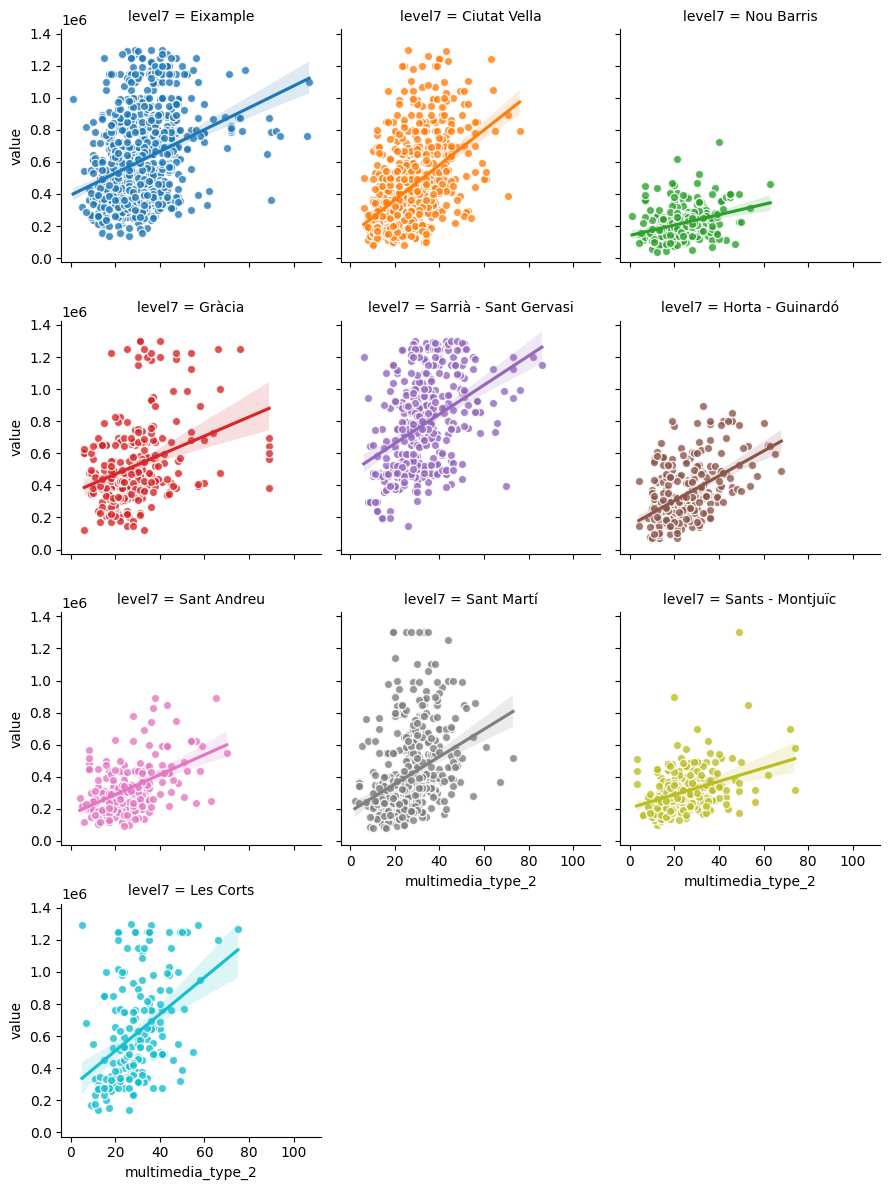

In [25]:
sns.lmplot(data=df_nonull, x="multimedia_type_2", y="value", col="level7", hue="level7",scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=3)
plt.show()

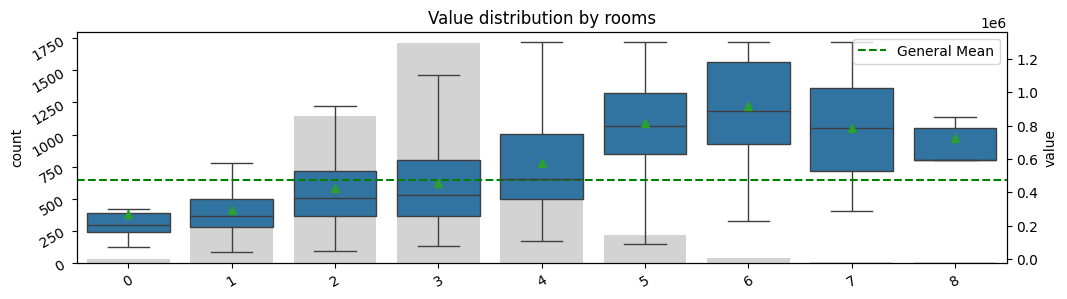

In [26]:
plot_boxplot_frequencies(["rooms"], ["rooms"], df_nonull)

## 3. Feature Engineering

The **feature engineering part** is where we leverage everything learned previously to create new features that can assist the model, modify them, and define which ones we will use and which ones we will not. \
We have tried different new variables. For example, a more general version of "floor_desc" ("floor_desc_grouped"), same floor_desc replacing nans with NA, ordinal encoding in "floor_desc" and creating a "is_floor_num" column, ordinal encoding of antiquity_desc...

Finally, **features that gave the best results are the "selected_feature" ones**, encoding the descriptive ones with one-hot encoding. They were all selected depending on what we see at EDA, and observing their performance on the model.

We also remove special characters for avoid issues in column names once created by the get dummies.

In [29]:
from unidecode import unidecode

def remove_accents(value):
    return unidecode(value) if isinstance(value, str) else value

def clean_values(data):
    data["level8"] = data["level8"].str.replace(r"[ '.,-]", "_", regex=True)
    data["floor_desc"] = data["floor_desc"].str.replace("ª","").str.replace(" ","")
    data[["level8"]] = data[["level8"]].applymap(remove_accents)
    data[["floor_desc"]] = data[["floor_desc"]].applymap(remove_accents)
    data[["antiquity_desc"]] = data[["antiquity_desc"]].applymap(remove_accents)
    data["antiquity_desc"] = data["antiquity_desc"].str.replace(r"anos|\s", "", regex=True)
    return data

df_feat = clean_values(df_nonull.copy())

In [30]:
df_feat = clean_values(df_nonull.copy())
df_feat["floor_desc_grouped"] = df_feat["floor_desc"].replace({"Subsótano":"Sótano", "Bajos":"Baj-Entre","Entresuelo":"Baj-Entre",
                                                        "10ª planta":">=10ª planta","11ª planta":">=10ª planta","12ª planta":">=10ª planta",
                                                        "13ª planta":">=10ª planta","14ª planta":">=10ª planta","15ª planta":">=10ª planta",
                                                        "A partir de la 15ª planta":">=10ª planta"})

df_feat["floor_desc_NA"] = df_feat["floor_desc"].fillna("NA")
df_feat["floor_desc_grouped_NA"] = df_feat["floor_desc_grouped"].fillna("NA")

df_feat["floor_ordinal_nans"] = np.where(df_feat["floor"]>0, df_feat["floor"], np.nan)
df_feat["is_floor_num"] = np.where(df_feat["floor"]>=6, True, False)



In [32]:
selected_features = ["rooms", "bathrooms", "surface","level8","energy_letter","environment_letter","energy_value","environment_value",
                         "floor_desc", "elevator","parking","Aire acondicionado","Parquet","Serv. portería","Balcón","Armarios","Calefacción",
                         "Suite - con baño","Terraza","Alarma","Cocina Equipada","Piscina","Gres Cerámica","Jardín Privado","Trastero"]

X = df_feat[selected_features]
y = df_feat["value"]

X_encoded = pd.get_dummies(X, columns=['level8','energy_letter','environment_letter','floor_desc'], drop_first=True)


## 4. Model

In [33]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV


### 4.1. Model Training

**After trying several regressors** (linear regressor, lightboost, random forest, catboost), the one that gave us a better approach is the **XGBRegressor**.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=76)

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mse:.1f}')


Mean Absolute Error on Test Set: 74776.0


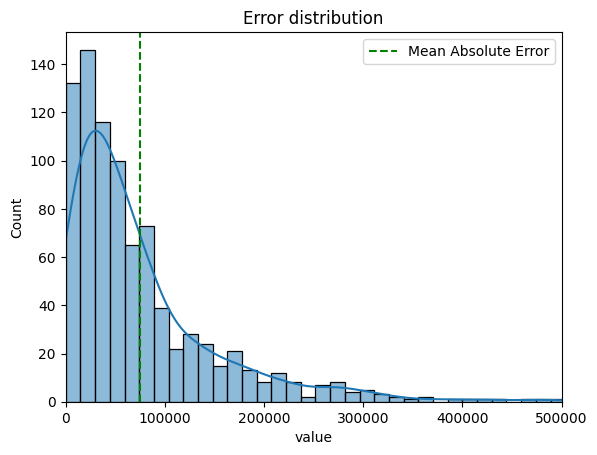

In [35]:
sns.histplot(abs(y_pred-y_test), kde=True)
plt.axvline(x=np.mean(abs(y_test-y_pred)), color='g', linestyle='--', label='Mean Absolute Error')
plt.xlim([0,500000])
plt.legend()
plt.title("Error distribution")
plt.show()

### 4.2. Model Optimization

A MAE of around 75000€ is a really good result, considering that a flat value can arive to more than 1M, and the mean value is around 400.000€.
However, we always have to do a Randomized/Grid search to see if can be more obtimized, and achieve even better results.

In [37]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


In [38]:
model = XGBRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50,
                                   scoring='neg_mean_absolute_error', cv=5, verbose=1, random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Best Model's Mean Absolute Error on Test Set: {mae:.1f}")
best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Model's Mean Absolute Error on Test Set: 70935.1
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


**We have reduced the average error** around 5.000€, that represents the % of the previous MAE. Good news for our model.


### 4.3. Model Evaluation

Apart from the power that a model can give to us at the future, giving the possibility to predict the price of a flat given some features, we can extract conclusions from the model itself, extracting the feature importances, and see which features are more relevant to decide our target.

A really good study can be done using SHAP values, but it is high memory and time demanding, and impossible to run in my local environment.

In [39]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame
indices = np.argsort(feature_importances)[::-1]


In [51]:
df_features = pd.DataFrame({"feature_names":feature_names[indices],"feature_importances":feature_importances[indices]})

def extract_feature_group(feature_name):
    if feature_name.startswith('level8'):
        return 'level8'
    elif feature_name.startswith('floor_desc'):
        return 'floor_desc'
    elif feature_name.startswith('environment_l'):
        return 'environment'
    elif feature_name.startswith('energy_l'):
        return 'energy'
    else:
        return feature_name


df_features['feature_group'] = df_features['feature_names'].apply(extract_feature_group)
df_features_grouped = df_features[["feature_importances","feature_group"]].groupby("feature_group").mean().sort_values("feature_importances", ascending=False).reset_index()


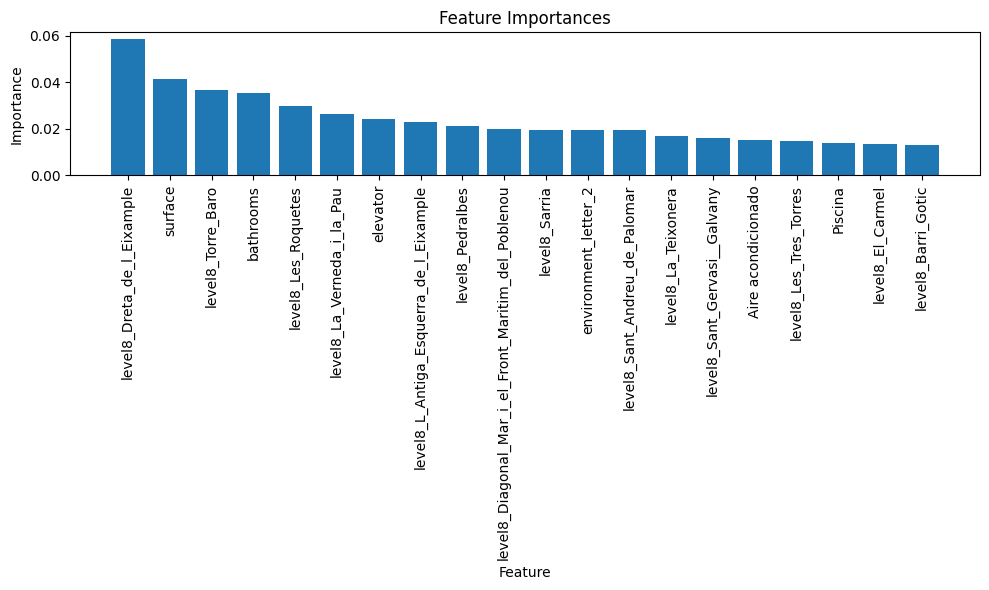

In [52]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(20), feature_importances[indices][:20], align="center")
plt.xticks(range(20), feature_names[indices][:20], rotation=90)  # Use feature names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

As expected (thanks to our previous analysis) the most relevant features are the ones generated by the neighborhood, surface, bathrooms, elevator, environment letter, climatization and pool. To avoid seeing too many geographical features, I have grouped the features created with the one-hot encoding into their respective group.

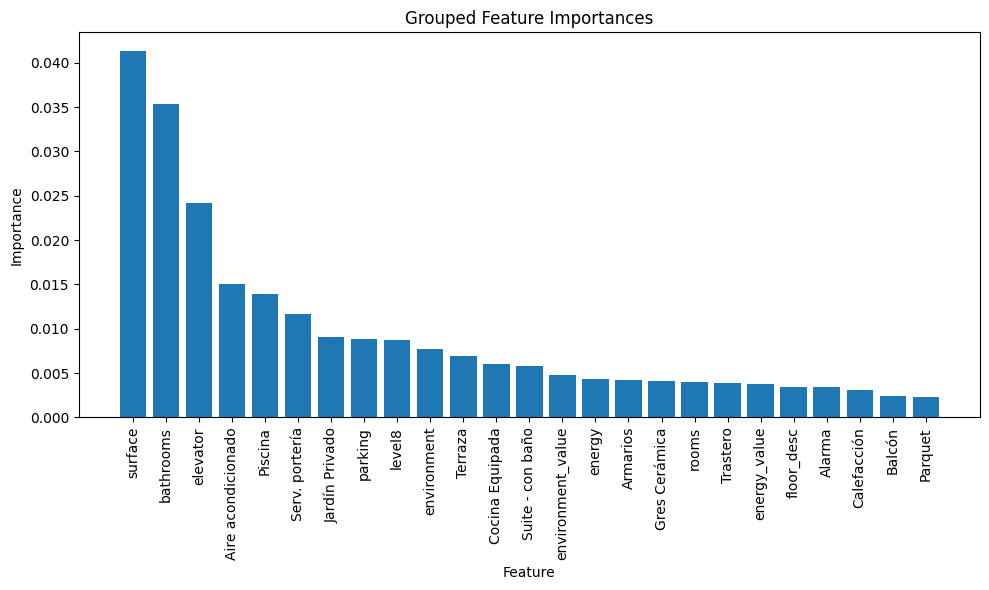

In [53]:
plt.figure(figsize=(10, 6))
plt.title("Grouped Feature Importances")
plt.bar(range(len(df_features_grouped.feature_importances)), df_features_grouped.feature_importances, align="center")
plt.xticks(range(len(df_features_grouped.feature_group)), df_features_grouped.feature_group, rotation=90)  # Use feature names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()